# TFRecord
---
In this notebook, I'll describe how to use the TFRecord API in your training.  

## Table of contents
---
- Overview and utility functions  
- tf.python_io API (Recommended)         
- tf.data.Dataset API

Packages:

In [1]:
import tensorflow as tf
import numpy as np
import gzip
import os
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)

tensorflow version:  1.15.2
numpy version:  1.18.2


Define functions to load mnist dataset:

In [2]:
def load_mnist_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1,784)
        return data.reshape(-1, 28, 28, 1)
    
def load_mnist_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

In [3]:
url_base = 'http://yann.lecun.com/exdb/mnist/'

dataset_dir = './../../data/mnist/'

filenames = {
    'test_images':'t10k-images-idx3-ubyte.gz',
    'test_labels':'t10k-labels-idx1-ubyte.gz',
    'train_images':'train-images-idx3-ubyte.gz',
    'train_labels':'train-labels-idx1-ubyte.gz'
}

os.makedirs(dataset_dir, exist_ok=True)

for filename in filenames.values():
    if not os.path.exists(dataset_dir + filename):
        urllib.request.urlretrieve(url_base + filename, dataset_dir + filename)

## Overview and utility functions
---
### Overview
- We should convert data into `tf.Example`.
    - The `tf.Example` is a class for saving data as a serialized binary-string format.
    - The `tf.Example` is made from `tf.train.Features`.
    - The `tf.train.Features` is made from dictionaies of `tf.train.Feature` like `{"string": tf.train.Feature}`.
        - The `tf.train.Feature` can take following fixed length list data types.
            - tf.train.BytesList (the following types can be coerced)
                - string
                - byte
            - tf.train.FloatList (the following types can be coerced)
                - float (float32)
                - double (float64)
            - tf.train.Int64List (the following types can be coerced)
                - bool
                - enum
                - int32
                - uint32
                - int64
                - uint64

#### Define functions for data type convertion for the TFRecord format
Note that we should put data as an 1-D List.

In [4]:
# The following functions can be used to convert a value to a type compatible with tf.Example.
## Reference: https://www.tensorflow.org/tutorials/load_data/tf_records#writing_a_tfrecord_file

# We have to wrap as 1D list in case the value is scalar

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value])) 

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

## tf.python_io API (Recommended)
---
Reference:  
- https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/convert_to_records.py
    
### Writing a TFRecord file
---
- Writing a TFRecord file 
    -  Making a TFRecord format
        - Serialize data using `tf.train.Example` function
    - Writing a TFRecord file
        - `tf.python_io.TFRecordWriter`

#### Define functions

In [5]:
def make_example(label, image):
    '''
    Convert numpy data into tf.train.Example format
    # Arguments
        label: Categolical label data
        image: 4-D tensor image data of shape [height, width, channels]
    # Returns
        Single (label, image) pair packed as tf.train.example
    '''
    image_raw = image.tostring()
    height = image.shape[0]
    width = image.shape[1]
    channels = image.shape[2]
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'height': _int64_feature(height),
                'width': _int64_feature(width),
                'depth': _int64_feature(channels),
                'label': _int64_feature(int(label)),
                'image_raw': _bytes_feature(image_raw)
            }
        )
    )
    return example

In [6]:
def convert_to_tfrecord(images, labels, path):
    """Converts a numpy format dataset to tfrecords."""
    num_examples = len(labels)
    if images.shape[0] != num_examples:
        raise ValueError('Images size %d does not match label size %d.' % (images.shape[0], num_examples))
    
    print('Writing', path)
    with tf.python_io.TFRecordWriter(path) as writer:
        for idx in range(num_examples):
            example = make_example(labels[idx], images[idx])
            writer.write(example.SerializeToString())

#### Load MNIST dataset

In [7]:
X_train = load_mnist_images(dataset_dir + filenames['train_images'])
y_train = load_mnist_labels(dataset_dir + filenames['train_labels'])
X_test = load_mnist_images(dataset_dir + filenames['test_images'])
y_test = load_mnist_labels(dataset_dir + filenames['test_labels'])

#### Write TFRecords

In [8]:
convert_to_tfrecord(X_train, y_train, dataset_dir + "train_mnist_python_io.tfrecord")
convert_to_tfrecord(X_test, y_test, dataset_dir + "test_mnist_python_io.tfrecord")

Writing ./../../data/mnist/train_mnist_python_io.tfrecord
Writing ./../../data/mnist/test_mnist_python_io.tfrecord


### Reading a TFRecord file
---
- Reading a TFRecord file
    - `tf.TFRecordReader`
    - `tf.python_io.tf_record_iterator`

In [9]:
raw_image_dataset = tf.data.TFRecordDataset(dataset_dir + "train_mnist_python_io.tfrecord")

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.FixedLenFeature([], tf.int64),
    'width': tf.FixedLenFeature([], tf.int64),
    'depth': tf.FixedLenFeature([], tf.int64),
    'label': tf.FixedLenFeature([], tf.int64),
    'image_raw': tf.FixedLenFeature([], tf.string), # Byte feature should be load as type of tf.string
}

def _process_image(raw_image):
    '''Convert byte image into image tensor'''
    image = tf.decode_raw(raw_image, tf.uint8)
    image = tf.cast(image, dtype=tf.float32) / 255
    return tf.reshape(image, (28, 28, 1))

def _parse_function(example_proto):
    # Parse a single tf.Example using the dictionary above.
    feature = tf.parse_single_example(example_proto, image_feature_description)
    raw_image = feature['image_raw']
    image = _process_image(raw_image)
    label = tf.one_hot(feature['label'], depth=10)
    return image, label

# decode dataset
parsed_image_dataset = raw_image_dataset.map(_parse_function)

In [10]:
dataset = parsed_image_dataset.repeat(-1).batch(2) # Batch size is selected for debugging
iterator = dataset.make_one_shot_iterator()

# Ops for getting batch
next_element = iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


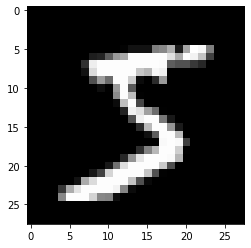

label [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


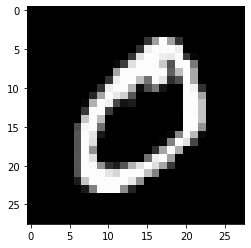

label [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
with tf.Session() as sess:
    batch_imgs,batch_labels = sess.run(next_element)
    for batch_img, batch_label in zip(batch_imgs, batch_labels):
        plt.imshow(batch_img[:,:,0])
        plt.gray()
        plt.show()
        print('label', batch_label)

## tf.data.Dataset API
---
In this section, I describe how to read/write a TFRecord file using tf.data.Dataset API. 

### Writing a TFRecord file
---
- Making a TFRecord format
    - serialize dataset using `map` function
- Writing a TFRecord file
    - `tf.data.experimental.TFRecordWriter`

#### Load mnist dataset

In [12]:
X_train = load_mnist_images(dataset_dir + filenames['train_images'])
y_train = load_mnist_labels(dataset_dir + filenames['train_labels'])
X_test = load_mnist_images(dataset_dir + filenames['test_images'])
y_test = load_mnist_labels(dataset_dir + filenames['test_labels'])

# Parse images into 1D lists of raw data byte
X_train = [_X.reshape(-1).tobytes() for _X in X_train]
X_test =  [_X.reshape(-1).tobytes() for _X in X_test]

# Parse categolical values into int32
y_train = np.int32(y_train)
y_test = np.int32(y_test)

#### Define a map function to serialize the mnist dataset

In [13]:
## Reference: https://www.tensorflow.org/tutorials/load_data/tf_records#writing_a_tfrecord_file

def serialize_example_mnist(X, y):
    """
    Creates a tf.Example message ready to be written to a file.
    This function parse a single dataset input into a serialized data.
    """
    
    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        'X': _bytes_feature(X),
        'y': _int64_feature(y),
    }
  
    # Create a message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize into binary-string format
    return example_proto.SerializeToString()

>The mapped function must operate in TensorFlow graph mode: It must operate on and return tf.Tensors. A non-tensor function, like serialize_example, can be wrapped with tf.py_function to make it compatible. We define a similar function serialize_example_pyfunction below with a minor change - converting eagerTensor objects returned by the tf.py_function to numpy arrays as required by our _bytes_feature, _float_feature and _int64_feature functions.

More detailed information is avalable in the [official site](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/tf_records.ipynb).

In [14]:
## Reference: https://www.tensorflow.org/tutorials/load_data/tf_records#writing_a_tfrecord_file

def serialize_example_mnist_pyfunc(X, y):
    """
    Creates a tf.Example message ready to be written to a file.
    This function parse a single dataset input into a serialized data.
    """
    
    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        'X': _bytes_feature(X.numpy()),     # Here is a change!!
        'y': _int64_feature(y.numpy()),     # Here is a change!!
    }
  
    # Create a message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize into binary-string format
    return example_proto.SerializeToString()

#### Create dataset objects

In [15]:
# Create source dataset for the training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
print(train_dataset)

# Create source dataset for the test
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
print(test_dataset)

<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int32)>
<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int32)>


#### Define function to map the tf.data.Dataset objects.

In [16]:
# Function for serializing data
def tf_serialize_example_mnist(X, y):
    tf_string = tf.py_function(
        serialize_example_mnist_pyfunc, 
        (X,y),          # pass these args to the above function.
        tf.string)      # the return type is <a href="../../api_docs/python/tf#string"><code>tf.string</code></a>.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [17]:
# Serialize each data using map function
serialized_mnist_train = train_dataset.map(tf_serialize_example_mnist)
serialized_mnist_test = test_dataset.map(tf_serialize_example_mnist)
print(serialized_mnist_train)
print(serialized_mnist_test)

<DatasetV1Adapter shapes: (), types: tf.string>
<DatasetV1Adapter shapes: (), types: tf.string>


#### Saving the serialized data as TFRecord file.

In [18]:
train_filename = 'train_mnist.tfrecord'
test_filename = 'test_mnist.tfrecord'

In [19]:
# Define ops to write TFRecord
writer_train = tf.data.experimental.TFRecordWriter(dataset_dir + train_filename)
write_ops_train = writer.write(serialized_mnist_train)

writer_test = tf.data.experimental.TFRecordWriter(dataset_dir + test_filename)
write_ops_test = writer1.write(serialized_mnist_test)

with tf.Session() as sess:
    sess.run(write_ops_train)
    sess.run(write_ops_test)

### Reading a TFRecord file
---
Reading process is the same as section above.

#### Reading a TFRecord file

In [20]:
# Put the filepath as list
train_record = tf.data.TFRecordDataset([dataset_dir + train_filename])
test_record = tf.data.TFRecordDataset([dataset_dir + test_filename])

#### Create a description of the features

In [21]:
feature_description = {
    'X': tf.FixedLenFeature([], tf.string, default_value=''),
    'y': tf.FixedLenFeature([], tf.int64, default_value=0),
}

#### Define function for mapping data

In [22]:
def _process_image(raw_image):
    '''Convert byte image into image tensor'''
    image = tf.decode_raw(raw_image, tf.uint8)
    image = tf.cast(image, dtype=tf.float32) / 255
    return tf.reshape(image, (28, 28, 1))

def _parse_function(example_proto):
    # Parse a single tf.Example using the dictionary above.
    feature = tf.parse_single_example(example_proto, feature_description)
    raw_image = feature['X']
    image = _process_image(raw_image)
    label = tf.one_hot(feature['y'], depth=10)
    return image, label

#### Apply the function

In [23]:
train_record_dataset = train_record.map(_parse_function)
test_record_dataet = test_record.map(_parse_function)

(Optional) Pre-processing

In [24]:
train_record_dataset = train_record_dataset.repeat(-1).batch(8) # Batch size is selected for debugging.
iterator = train_record_dataset.make_one_shot_iterator()
next_data = iterator.get_next()

(8, 28, 28, 1)


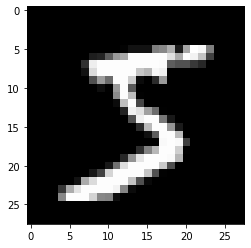

label:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


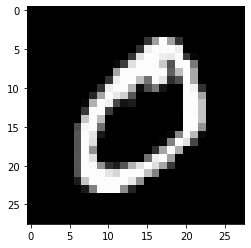

label:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


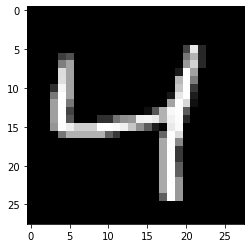

label:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


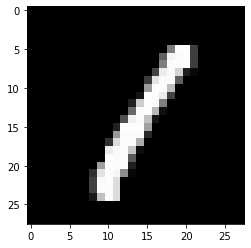

label:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


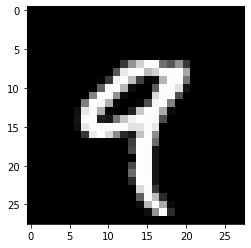

label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


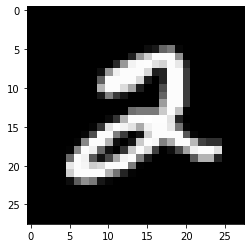

label:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


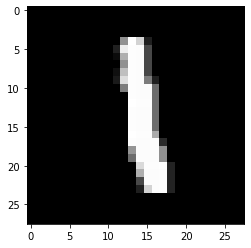

label:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


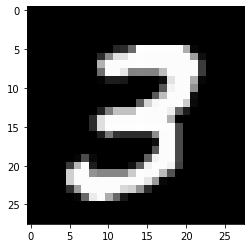

label:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [25]:
with tf.Session() as sess:
    for ii in range(1):
        imgs, labels = sess.run(next_data)
        print(imgs.shape)
        for img, label in zip(imgs, labels):
            plt.imshow(img[:,:,0])
            plt.show()
            print('label: ', label)

More informations:  
https://www.tensorflow.org/guide/datasets#consuming_tfrecord_data